In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# Camera calibration with chessboard images

In [ ]:
def load_imgs(path):
    return [mpimg.imread(e) for e in glob.glob(path)]

def show_img_pairs(imgs1, imgs2, title1='', title2='', cmap1=None, cmap2=None):
    for img1, img2 in zip(imgs1, imgs2):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        
        ax1.imshow(img1, cmap=cmap1)
        ax1.set_title(title1, fontsize=30)
    
        ax2.imshow(img2, cmap=cmap2)
        ax2.set_title(title2, fontsize=30)
        
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def get_mapping(chessboard_imgs, chessboard_size):
    obj_pts = np.zeros((chessboard_size[0]*chessboard_size[1],3), np.float32)
    obj_pts[:,:2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1,2)

    objs_pts = []
    imgs_pts = []

    for idx, img in enumerate(chessboard_imgs):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        if ret == True:
            objs_pts.append(obj_pts)
            imgs_pts.append(corners)
            cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
            
    return objs_pts, imgs_pts

chessboard_imgs = load_imgs('camera_cal/calibration*.jpg')
chessboard_shape = chessboard_imgs[0].shape[:2]
chessboard_size = (9, 6)

objs_pts, imgs_pts =  get_mapping(chessboard_imgs, chessboard_size)
_, mtx, dist, _, _ = cv2.calibrateCamera(objs_pts, imgs_pts, chessboard_shape, None, None)
    
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

undist_imgs = [undistort(img) for img in chessboard_imgs]
show_img_pairs(chessboard_imgs, undist_imgs, title1='original', title2='undistroted')

# Undistorting test images

In [ ]:
test_imgs = load_imgs('test_images/*.jpg')
undist_imgs = [undistort(img) for img in test_imgs]
show_img_pairs(test_imgs, undist_imgs, title1='original', title2='undistorted')

# Filters for thresholding

In [ ]:
def sobel_thresh(img, orient='x', ksize=3, thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    dx = 1 if orient == 'x' else 0
    dy = 1 if orient == 'y' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, dx, dy, ksize=ksize)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    mask = np.zeros_like(scaled)
    mask[(thresh[0] <= scaled) & (scaled <= thresh[1])] = 1
    return mask

def mag_thresh(img, ksize=5, thresh=(40, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * mag / np.max(mag))
    mask = np.zeros_like(scaled)
    mask[(thresh[0] <= scaled) & (scaled <= thresh[1])] = 1
    return mask

def direct_thresh(rgb, ksize=5, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    absx = np.abs(sobelx)
    absy = np.abs(sobely)
    direct = np.arctan2(absy, absx)
    mask = np.zeros_like(direct)
    mask[(thresh[0] <= direct) & (direct <= thresh[1])] = 1
    return mask

def hls_thresh(img, channel=2, thresh=(160, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,channel]
    mask = np.zeros_like(s_ch)
    mask[(s_ch >= thresh[0]) & (s_ch <= thresh[1])] = 1
    return mask

def comb_thresh(img):
    sobelx = sobel_thresh(img, 'x', ksize=9, thresh=(20, 100))
    s = hls_thresh(img, channel=2, thresh=(160, 255))
    direct = direct_thresh(img, ksize=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(sobelx)
    combined[((sobelx == 1) | (s == 1)) & (direct == 1)] = 1
    return combined

binary_imgs = [comb_thresh(e) for e in undist_imgs]
show_img_pairs(undist_imgs, binary_imgs, cmap2='gray', title1='undistorted', title2='binary')

# Perspective transform

In [ ]:
straight_img = undist_imgs[4]

src_pts = np.float32([
    [275, 670],
    [1028, 670],
    [596, 450],
    [685, 450]
])

height, width = straight_img.shape[:2]
offset = 250

dst_pts = np.float32([
    [offset, height - 5],
    [width - offset, height - 5],
    [offset, 5],
    [width - offset, 5]
])

M = cv2.getPerspectiveTransform(src_pts, dst_pts)

def warp(img):
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

M_inv = np.linalg.inv(M)

def unwarp(img):
    height, width = img.shape[:2]
    return cv2.warpPerspective(img, M_inv, (width, height))

warped_img = warp(straight_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()

ax1.imshow(straight_img)
ax1.plot(src_pts[:,0], src_pts[:, 1], 'ro', markersize=10)
ax1.set_title('source points', fontsize=30)   

ax2.imshow(warped_img)
ax2.plot(dst_pts[:,0], dst_pts[:, 1], 'ro', markersize=10)
ax2.set_title('destination points', fontsize=30)
plt.show()

In [ ]:
warped_imgs = [warp(img) for img in binary_imgs]
show_img_pairs(binary_imgs, warped_imgs, cmap1='gray', cmap2='gray', title1='binary', title2='transformed')

# Pipeline for processing test images

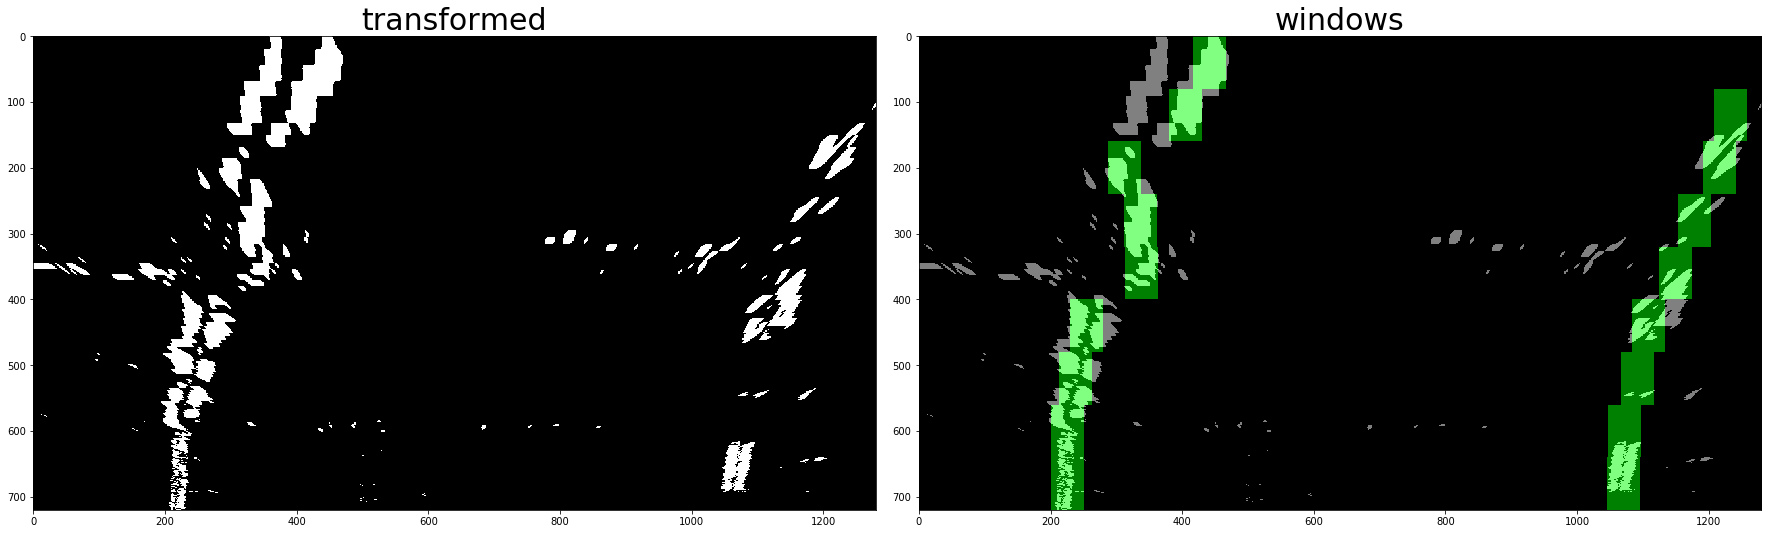

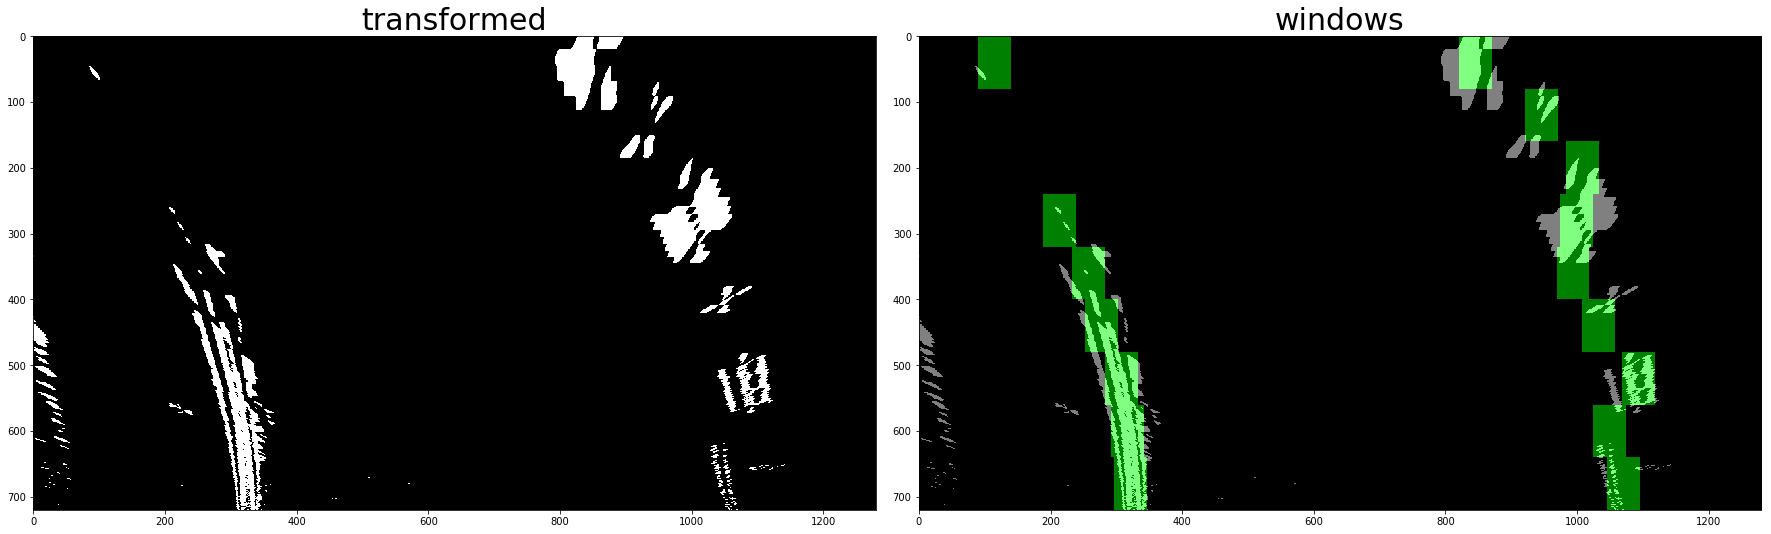

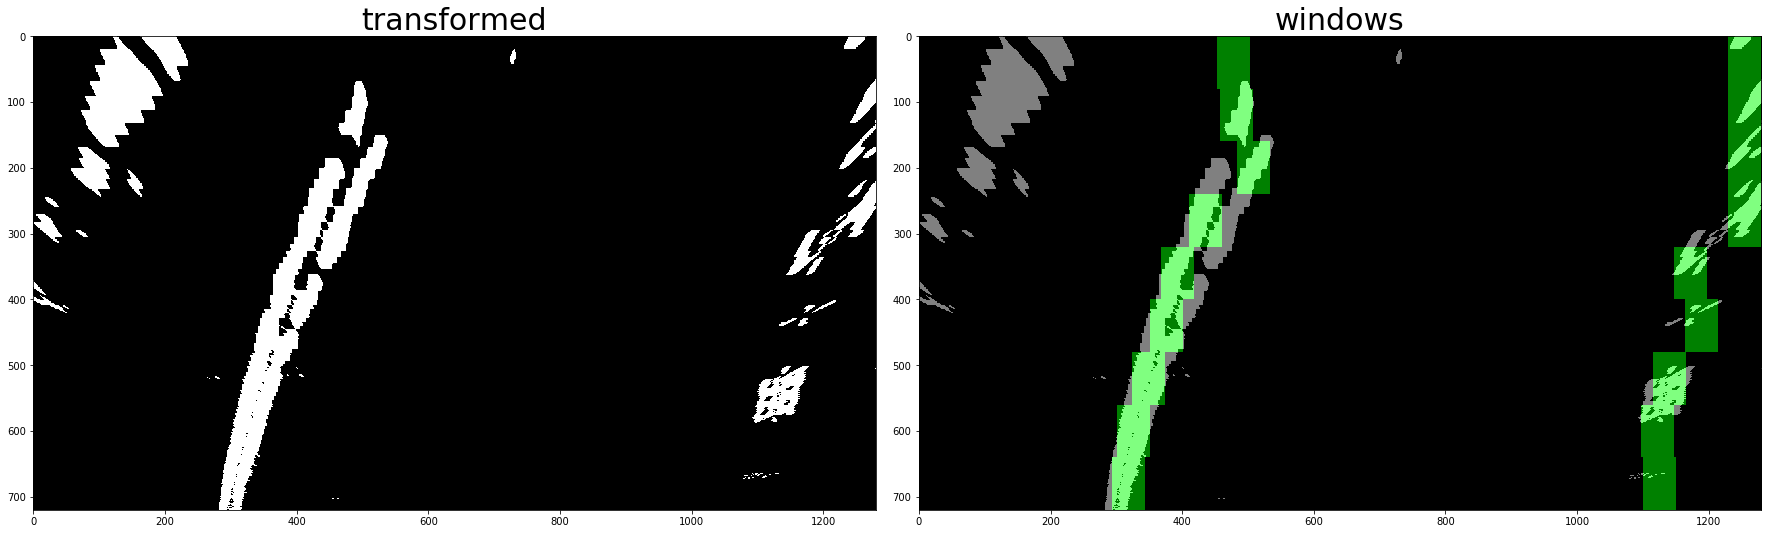

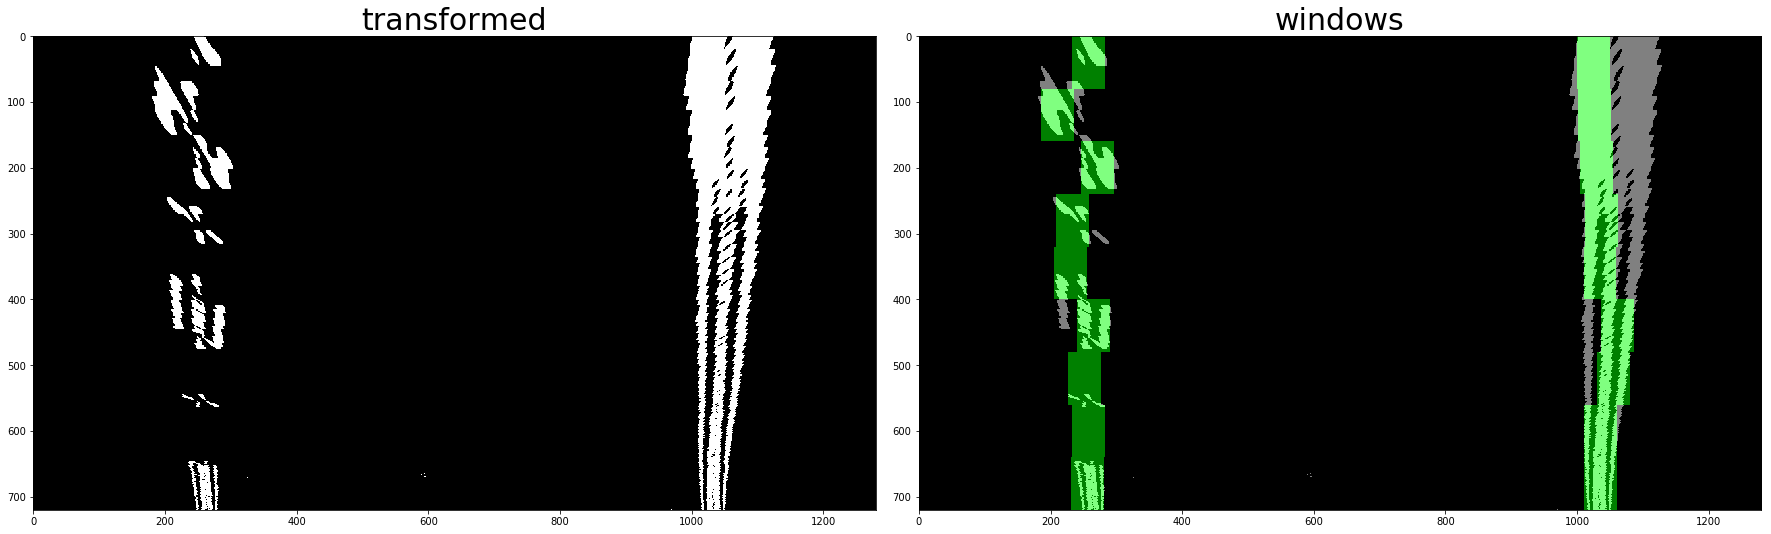

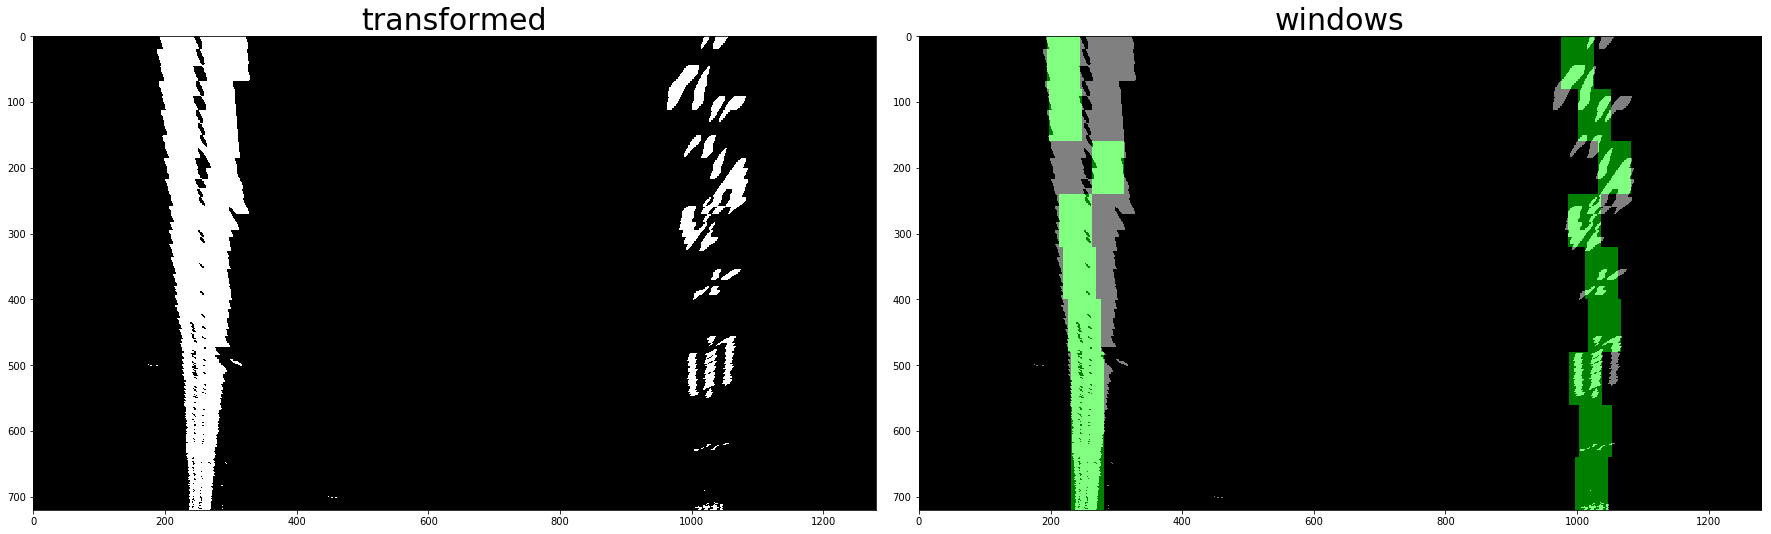

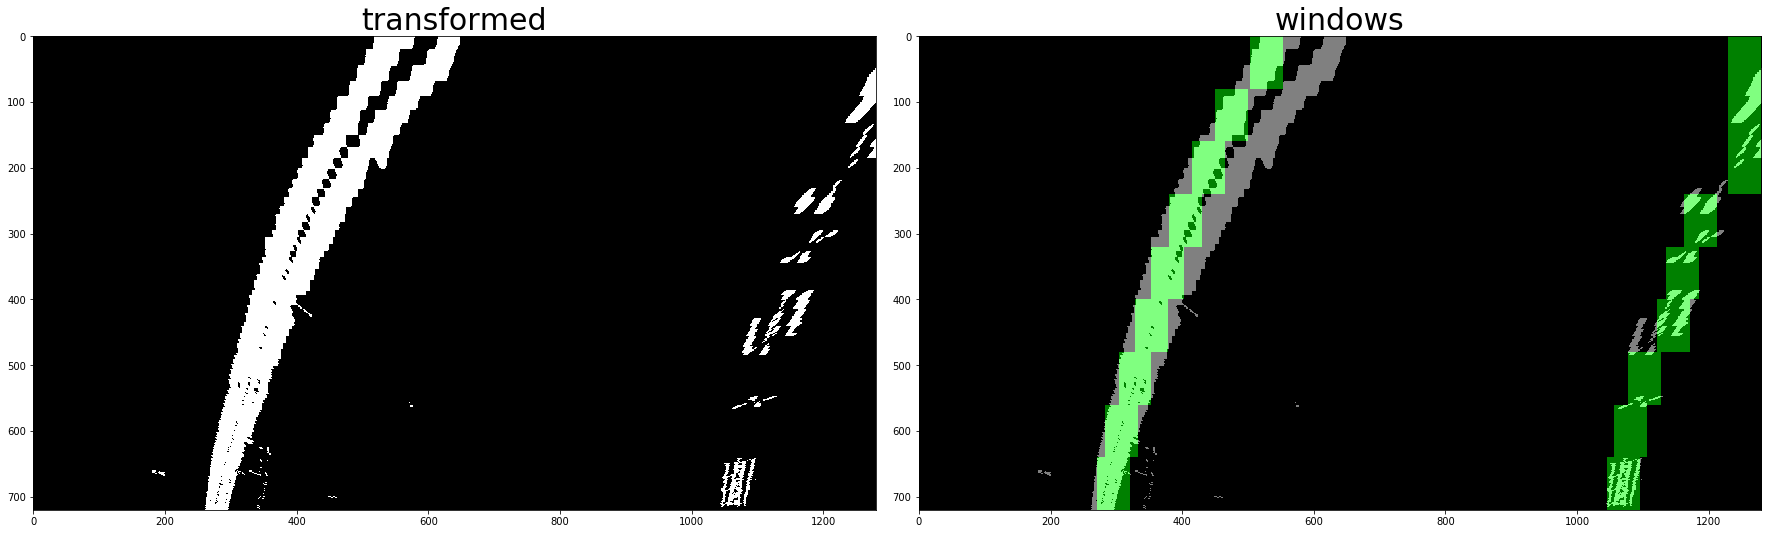

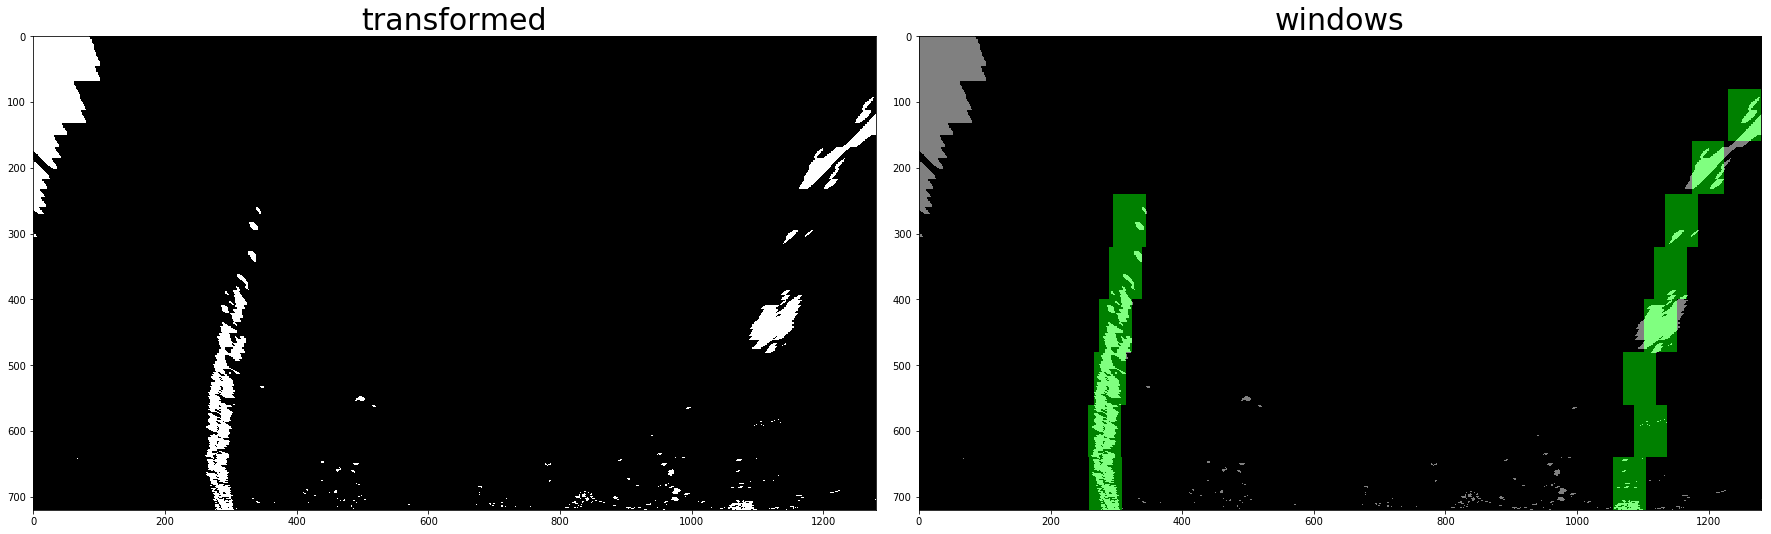

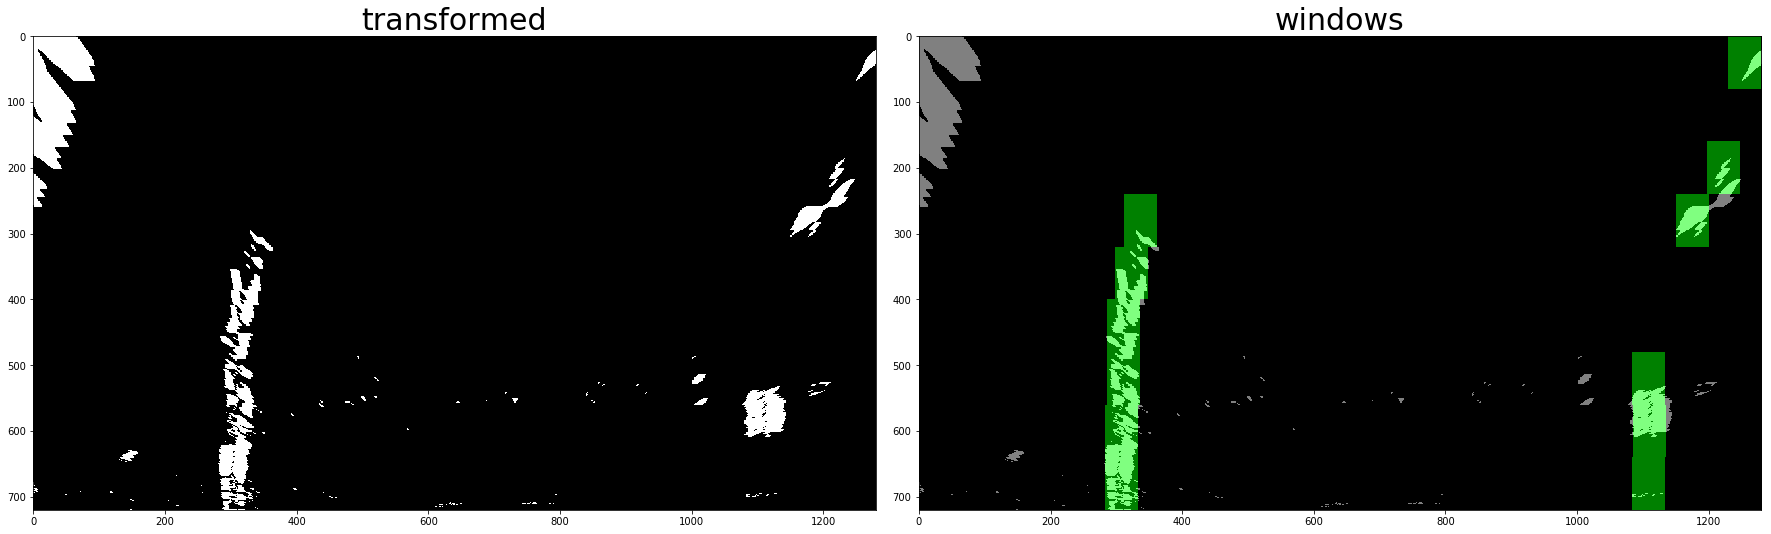

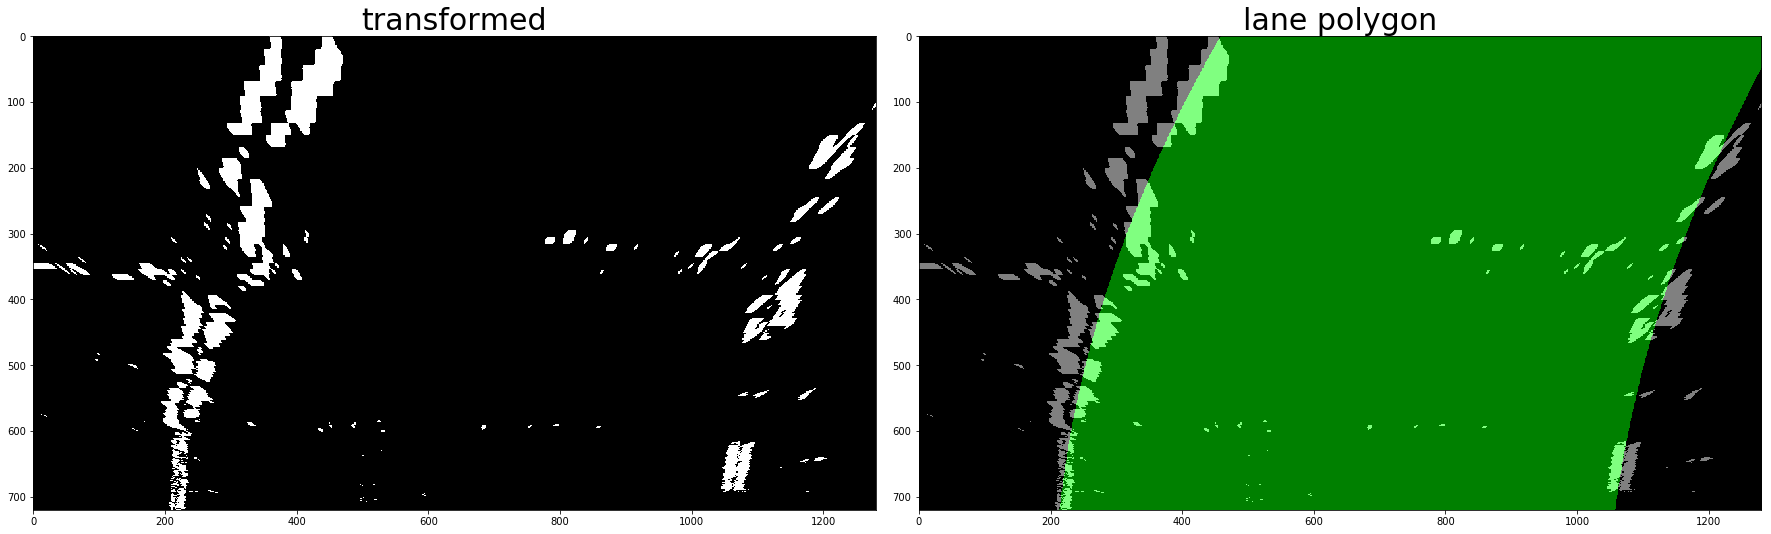

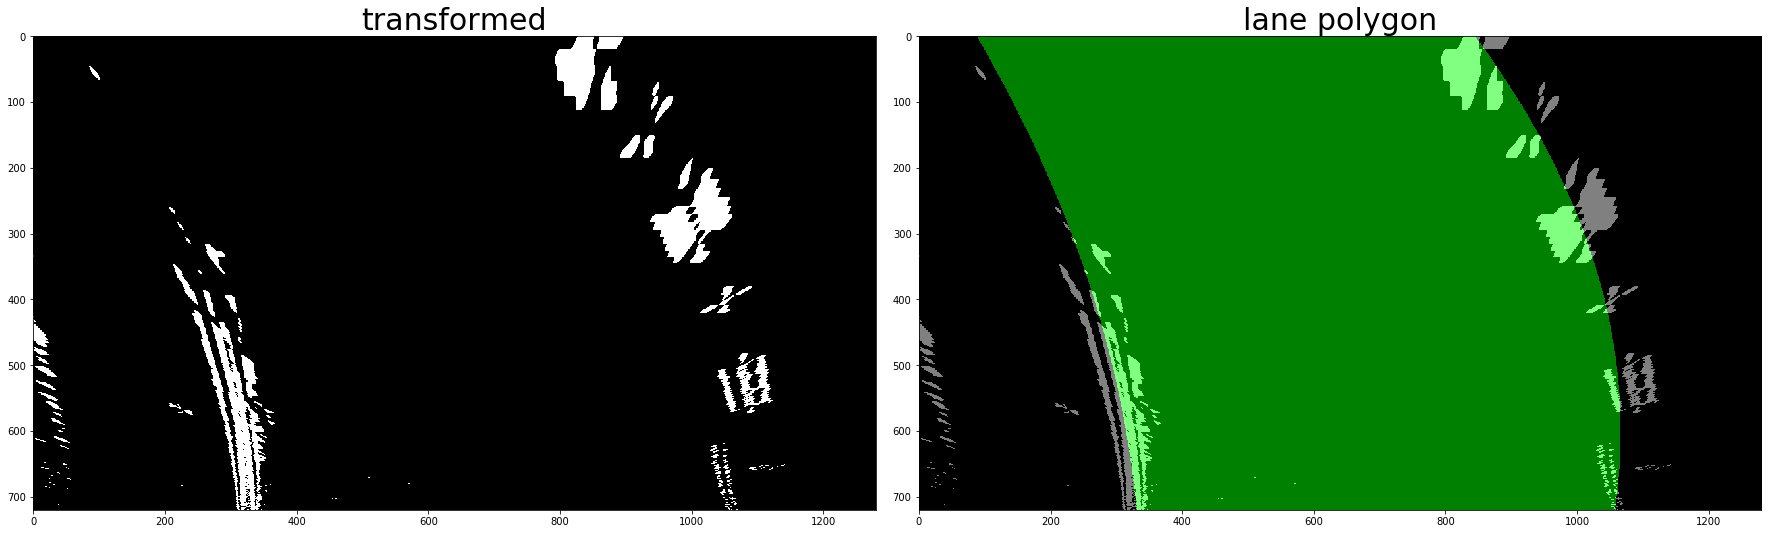

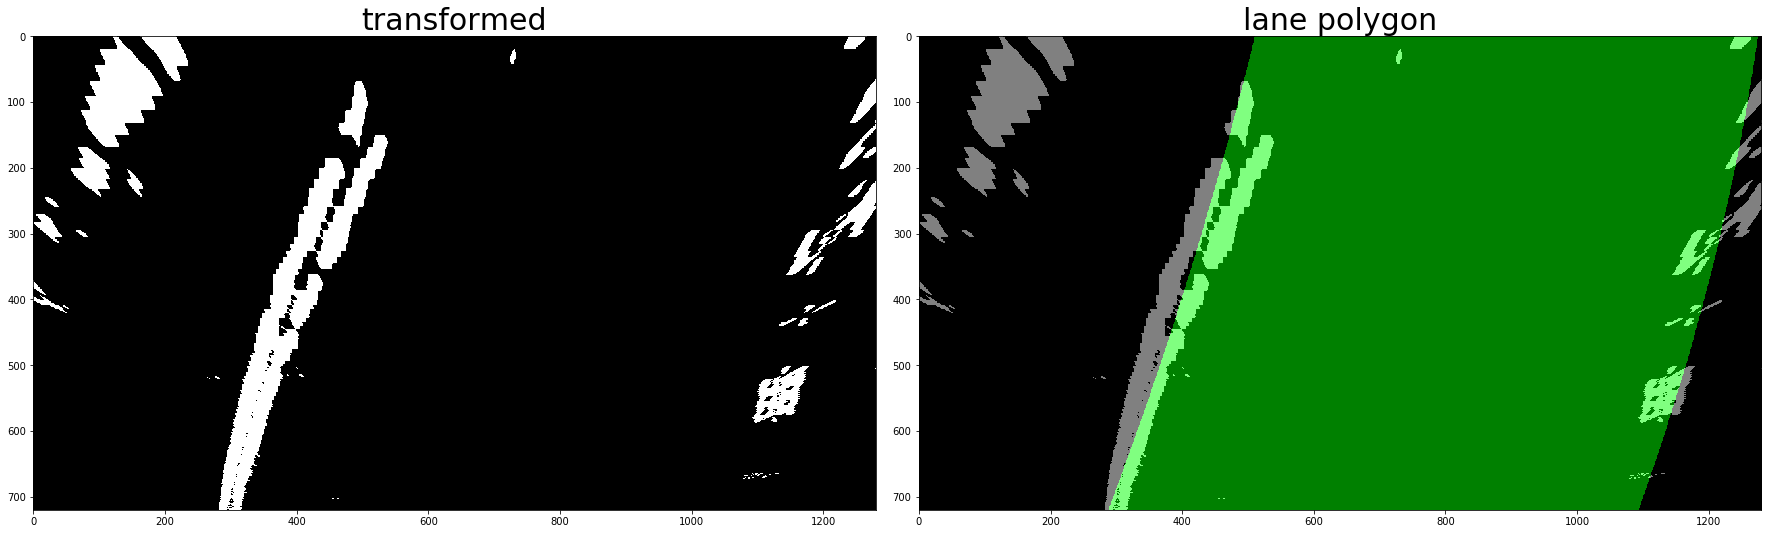

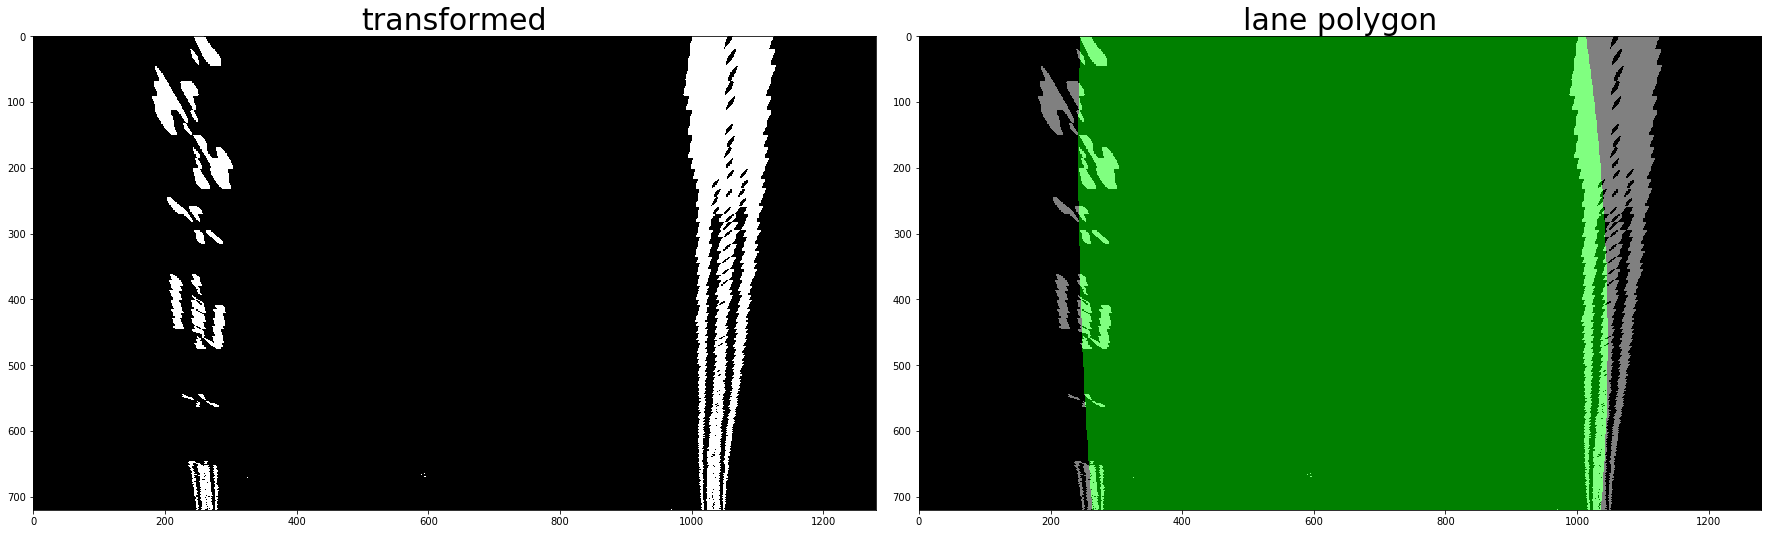

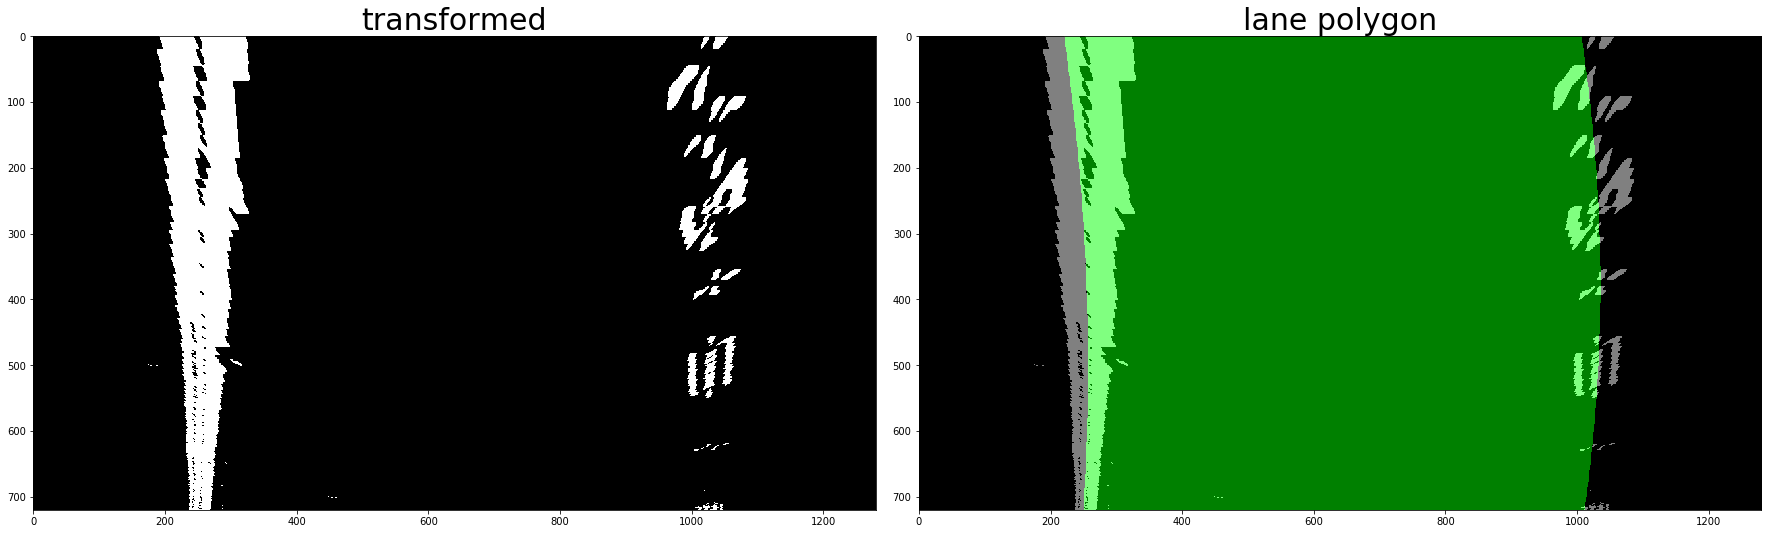

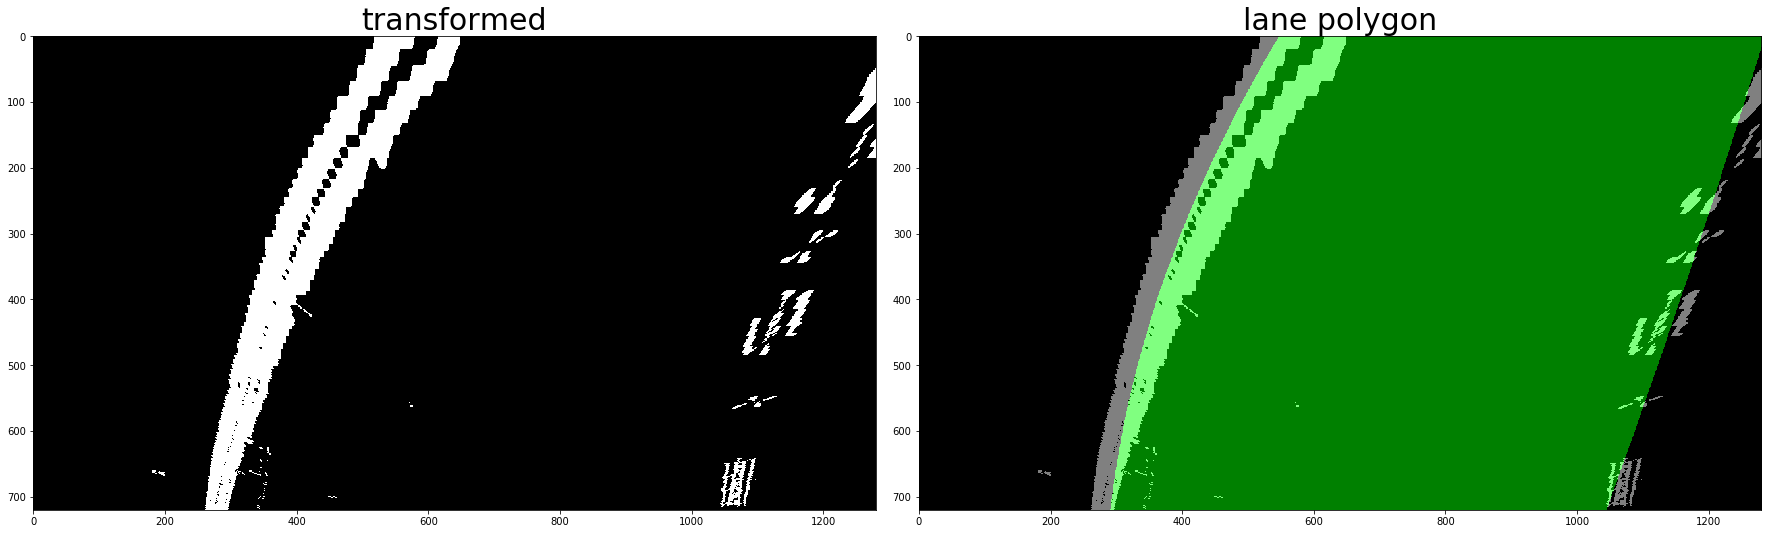

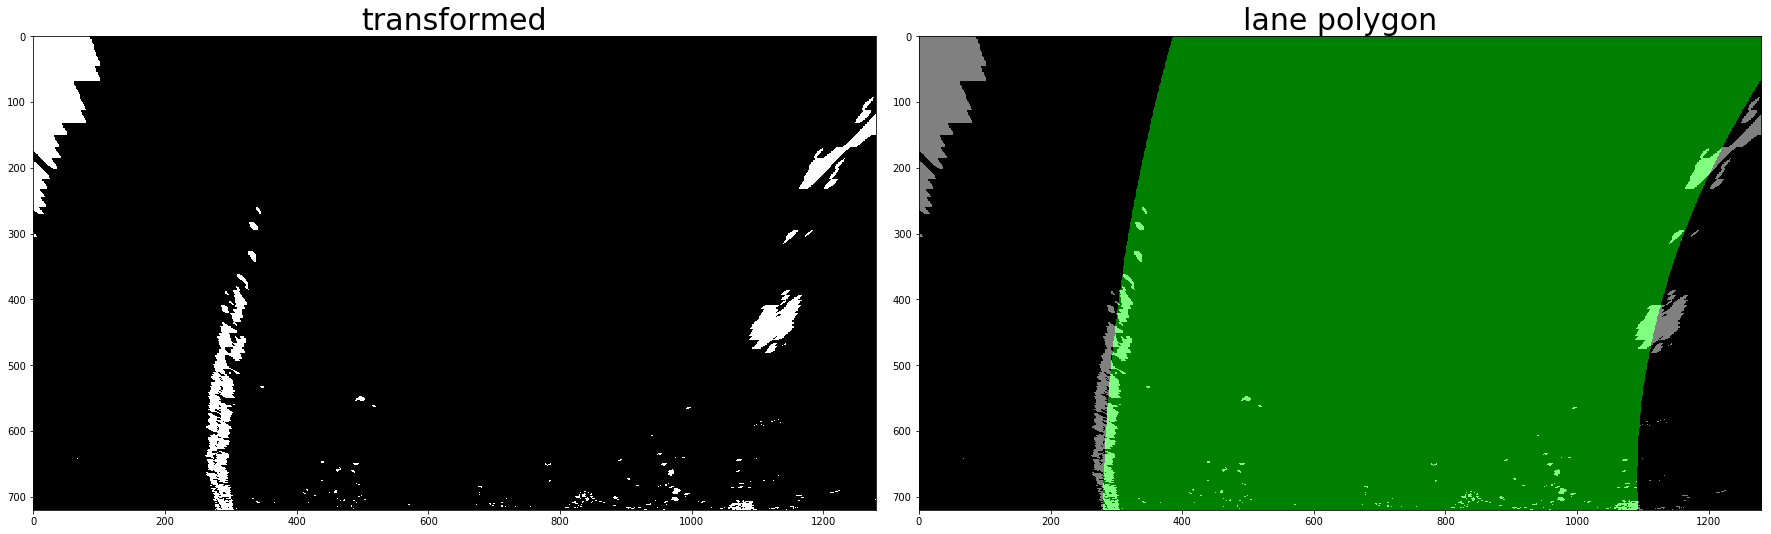

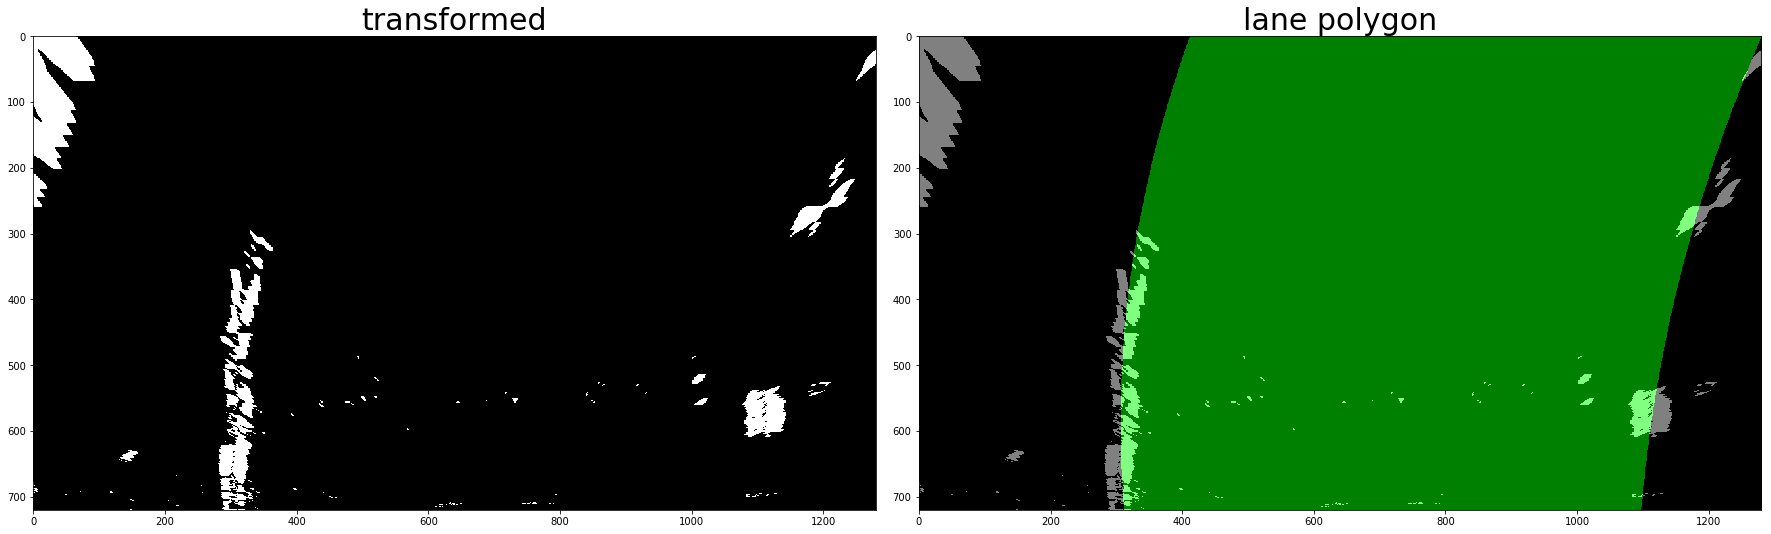

In [25]:
def find_next_x(prev_x, offset, margin, convolved_layer):
    min_index = max(prev_x + offset - margin, 0)
    max_index = min(prev_x + offset + margin, width)
    convolved = convolved_layer[min_index:max_index]
    
    if sum(convolved) == 0:
        return None
    else:
        return np.argmax(convolved) + min_index - offset

def get_level_y(level, window_height, height):
    return height - (level * window_height + int(window_height / 2))

def find_points(binary_img, window_size, window_margin):
    left_pts = []
    right_pts = []
    
    heigth, width = binary_img.shape
    window_width, window_height = window_size
    kernel = np.ones(window_width)
    
    y = get_level_y(0, window_height, height)
    
    left_sum = np.sum(binary_img[int(3 / 4 * height):, :int(width / 2)], axis=0)
    left_x = np.argmax(np.convolve(kernel, left_sum)) - int(window_width / 2)
    left_pts.append((left_x, y))
    
    right_sum = np.sum(binary_img[int(3 / 4 * height):, int(width / 2):], axis=0)
    right_x = np.argmax(np.convolve(kernel, right_sum)) - int(window_width / 2) + int(width / 2)
    right_pts.append((right_x, y))
    
    num_levels = (int)(height / window_height)
        
    for level in range(1, num_levels):
        y = get_level_y(level, window_height, height)
        layer = np.sum(binary_img[height - (level + 1) * window_height:height - level * window_height,:], axis=0)
        convolved = np.convolve(kernel, layer)
        offset = int(window_width / 2)
    
        next_left_x = find_next_x(left_x, offset, window_margin, convolved)
        
        if next_left_x is not None:
            left_x = next_left_x
            left_pts.append((left_x, y))
        
        next_right_x = find_next_x(right_x, offset, window_margin, convolved)
        
        if next_right_x is not None:
            right_x = next_right_x
            right_pts.append((right_x, y))
    
    return (np.array(left_pts), np.array(right_pts))

def draw_window(img_size, pt, window_size):
    height, width = img_size
    window_width, window_height = window_size
    
    x, y = pt

    x_min = max(int(x-window_width/2), 0)
    x_max = min(int(x+window_width/2), width)
    
    y_min = max(int(y-window_height/2), 0)
    y_max = min(int(y+window_height/2), height)

    output_img = np.zeros(img_size)
    output_img[y_min:y_max, x_min:x_max] = 1
    return output_img

def fit_lane(points):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

def draw_windows(binary_img, left_pts, right_pts, window_size):
    img_size = binary_img.shape
    overlay_img = np.zeros(img_size)
    
    for pt in left_pts:
        window_img = draw_window(img_size, pt, window_size)
        overlay_img[(window_img == 1) | (overlay_img == 1)] = 1
    
    for pt in right_pts:
        window_img = draw_window(img_size, pt, window_size)
        overlay_img[(window_img == 1) | (overlay_img == 1)] = 1
    
    overlay_img = np.array(overlay_img, np.uint8) * 255
    empty_img = np.zeros_like(overlay_img)
    overlay_img = np.array(cv2.merge((empty_img, overlay_img, empty_img)), np.uint8)
    color_img = np.dstack((binary_img, binary_img, binary_img))*128
    return cv2.addWeighted(color_img, 1, overlay_img, 0.5, 0.0)
    
def draw_fit_overlay(binary, left_points, right_points):
    (height, width) = binary.shape
    left_fit = np.polyfit(left_points[:,1], left_points[:,0], 2)
    right_fit = np.polyfit(right_points[:,1], right_points[:,0], 2)
    
    plot_y = np.linspace(0, height - 1, height)
    left_fit_x = left_fit[0]*plot_y**2+left_fit[1]*plot_y+left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2+right_fit[1]*plot_y+right_fit[2]
    
    overlay = np.zeros_like(binary).astype(np.uint8)
    overlay = np.dstack((overlay, overlay, overlay))

    left_plot_points = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
    right_plot_points = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
    plot_points = np.hstack((left_plot_points, right_plot_points))

    cv2.fillPoly(overlay, np.int_([plot_points]), (0, 255, 0))
    return overlay

def draw_fit(binary, left_points, right_points):
    overlay = draw_fit_overlay(binary, left_points, right_points)
    color = np.dstack((binary, binary, binary))*255
    return cv2.addWeighted(color, 1, overlay, 0.5, 0.0)

def get_curvature(points, m_per_pix):
    x = points[:,0]*m_per_pix[0]
    y = points[:,1]*m_per_pix[1]
    y_eval = np.max(y)
    fit = np.polyfit(y, x, 2)
    return ((1+(2*fit[0]*y_eval+fit[1])**2)**1.5)/np.absolute(2*fit[0])

win_size = (50, 80)
win_margin = 100
m_per_pix= (3.7/700, 30.0/720)

window_imgs = []
fit_imgs = []
poly_imgs = []
unwarped_imgs = []
final_imgs = []

(height, width) = test_imgs[0].shape[:-1]
img_size = (width, height)    

for i in range(len(test_imgs)):
    binary = warped_imgs[i]
    left_pts, right_pts = find_points(binary, win_size, win_margin)
    left_curvature = get_curvature(left_pts, m_per_pix)
    right_curvature = get_curvature(right_pts, m_per_pix)
    
    window_imgs.append(draw_windows(binary, left_pts, right_pts, win_size))
    fit_imgs.append(draw_fit(binary, left_pts, right_pts))
    
    overlay_img = draw_fit_overlay(binary, left_pts, right_pts)
    poly_imgs.append(cv2.addWeighted(np.dstack((binary * 128, binary * 128, binary * 128)), 1, overlay_img, 0.5, 0.0))
    
    unwarped_img = unwarp(overlay_img)
    unwarped_imgs.append(unwarped_img)
    
    final_img = cv2.addWeighted(test_imgs[i], 1, unwarped_img, 0.5, 0.0)
    final_imgs.append(final_img)
    
show_img_pairs(warped_imgs, window_imgs, cmap1='gray', title1='transformed', title2='windows')
show_img_pairs(warped_imgs, poly_imgs, cmap1='gray', title1='transformed', title2='lane polygon')

# Video pipeline

In [26]:
def get_curvature(fit, y):
    return ((1+(2*fit[0]*y+fit[1])**2)**1.5)/np.absolute(2*fit[0])

def eval_x(fit, y):
    return fit[0]*y**2+fit[1]*y+fit[2]

def draw_lanes_poly(shape, left_fit, right_fit):
    (height, width) = shape
    
    y = np.linspace(0, height - 1, height)
    left_x = eval_x(left_fit, y)
    right_x = eval_x(right_fit, y)
    
    output = np.zeros((height, width, 3)).astype(np.uint8)

    left_points = np.array([np.transpose(np.vstack([left_x, y]))])
    right_points = np.array([np.flipud(np.transpose(np.vstack([right_x, y])))])
    plot_points = np.hstack((left_points, right_points))

    cv2.fillPoly(output, np.int_([plot_points]), (0, 255, 0))
    return output

def draw_text(img, text, position):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 2
    font_color = (0, 255, 0)
    line_type = 2
    cv2.putText(img, text, position, font, font_scale, font_color, line_type)

def find_close_points(binary_img, margin, left_fit, right_fit):
    nonzero = binary_img.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    left_eval_x = eval_x(left_fit, nonzero_y)
    left_lane_inds = ((left_eval_x - margin) < nonzero_x) & (nonzero_x < (left_eval_x + margin))

    right_eval_x = eval_x(right_fit, nonzero_y)
    right_lane_inds = ((right_eval_x - margin) < nonzero_x) & (nonzero_x < (right_eval_x + margin))

    left_pts = np.stack([nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]], axis=1)
    right_pts = np.stack([nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]], axis=1)
    return left_pts, right_pts

class Lane():
    def __init__(self, img_size, m_per_px, last_n):
        self.last_n = last_n
        self.m_per_px = m_per_px
        self.img_size = img_size 
        
        self.fit = None        
        self.curvature = None
        self.offset = None
        self.slope = None

        self.last_fits = []

    def update(self, pts):
        if len(pts) < 2:
            self.fit = None
            return

        self.fit = np.polyfit(pts[:,1], pts[:,0], 2)
        
        pts_m = pts*self.m_per_px
        fit_m = np.polyfit(pts_m[:,1], pts_m[:,0], 2)
        max_y = self.img_size[1]
        max_y_m = max_y*self.m_per_px[1]
        self.curvature = get_curvature(fit_m, max_y_m)
        
        mid_x = self.img_size[0] / 2
        eval_max_x = eval_x(self.fit, max_y)
        self.offset = abs(eval_max_x - mid_x)*self.m_per_px[0]
        
        eval_min_x = eval_x(self.fit, 0)
        self.slope = (eval_max_x - eval_min_x) / max_y

    def accept(self):
        self.last_fits.insert(0, self.fit)
        self.last_fits = self.last_fits[:self.last_n]
        
    def reject(self):
        self.fit = None
            
    def smooth_fit(self):
        if len(self.last_fits):
            return np.mean(self.last_fits, axis=0)

class LaneFinder():
    def __init__(self, img_size, win_size, win_margin, m_per_px, n_last):
        self.img_size = img_size
        self.win_size = win_size
        self.win_margin = win_margin
        self.m_per_px = m_per_px
        self.n_last = n_last
        
        self.left_lane = Lane(img_size, m_per_px, n_last)
        self.right_lane = Lane(img_size, m_per_px, n_last)
        

    def process(self, img):
        output_img = np.copy(img)
        
        height, width = img.shape[:2]
        undist_img = undistort(img)
        binary_img = comb_thresh(undist_img)
        warped_img = warp(binary_img)
        
        if self.left_lane.fit is None or self.right_lane.fit is None:
            left_pts, right_pts = find_points(warped_img, self.win_size, self.win_margin)
        else: 
            left_pts, right_pts = find_close_points(warped_img, self.win_margin, self.left_lane.fit, self.right_lane.fit)
        
        self.left_lane.update(left_pts)
        self.right_lane.update(right_pts)
        
        if self.left_lane.fit is not None and self.right_lane.fit is not None:
            curvature_diff = abs(self.left_lane.curvature - self.right_lane.curvature)
            curvature_check = self.left_lane.curvature > 800 or self.right_lane.curvature > 800 or curvature_diff < 500
            
            separation = self.left_lane.offset + self.right_lane.offset
            separation_check = 2.6 < separation < 6.4
            
            slope_diff = abs(self.left_lane.slope - self.right_lane.slope)
            slope_check = slope_diff < 0.2
            
            offset = abs(self.left_lane.offset - self.right_lane.offset)
            
            curvature_text = 'Curvature left {:.0f}, right {:.0f}'.format(
                self.left_lane.curvature, self.right_lane.curvature)
            draw_text(output_img, curvature_text, (50, 50))
            
            offset_text = 'Offset left {:.3f}, right {:.3f}, car {:.3f}'.format(
                self.left_lane.offset, self.right_lane.offset, offset)
            draw_text(output_img, offset_text, (50, 100))
            
            slope_text = 'Slope left {:.3f}, right {:.3f}'.format(
                self.left_lane.slope, self.right_lane.slope)
            draw_text(output_img, slope_text, (50, 150))

            diff_text = 'Diff curvature {:.3f}, separation {:.3f}, slope {:.3f}'.format(
                curvature_diff, separation, slope_diff)
            draw_text(output_img, diff_text, (50, 200))
            
            check_text = 'Check curvature {}, separation {}, slope {}'.format(curvature_check, separation_check, slope_check)
            draw_text(output_img, check_text, (50, 250))
        
            if curvature_check and separation_check and slope_check:
                self.left_lane.accept()
                self.right_lane.accept()
            else:
                self.left_lane.reject()
                self.right_lane.reject()

        left_fit = self.left_lane.smooth_fit()
        right_fit = self.right_lane.smooth_fit()
        
        if left_fit is not None and right_fit is not None:
            poly_img = draw_lanes_poly(warped_img.shape, left_fit, right_fit)
            unwarped_img = unwarp(poly_img)
            output_img = cv2.addWeighted(output_img, 1, unwarped_img, 0.5, 0.0)
        
        return output_img

## Video pipeline can be also used to process images

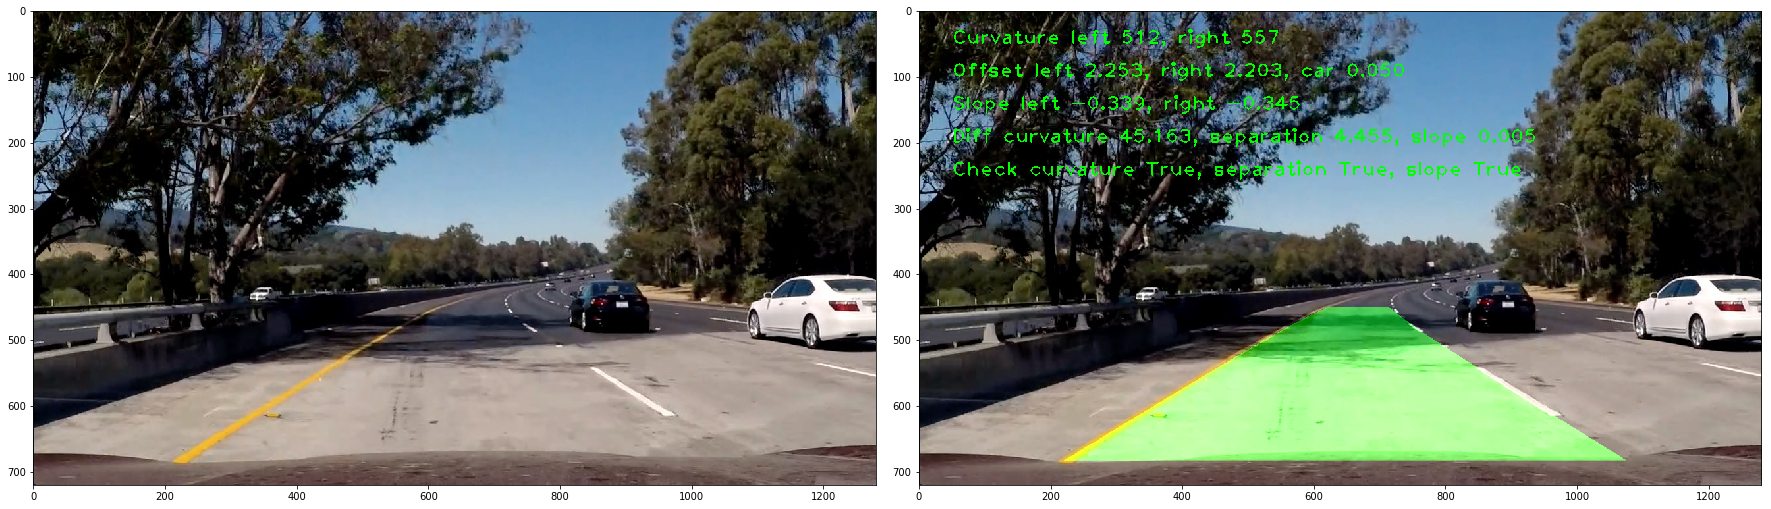

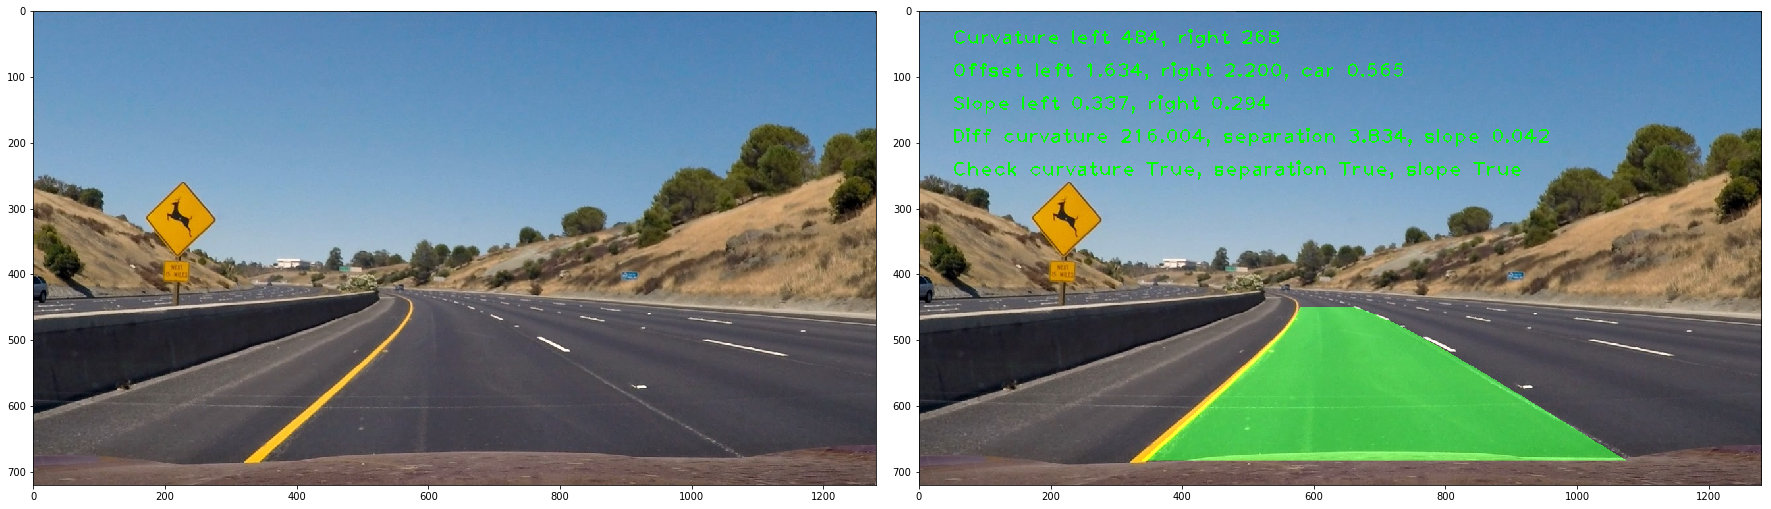

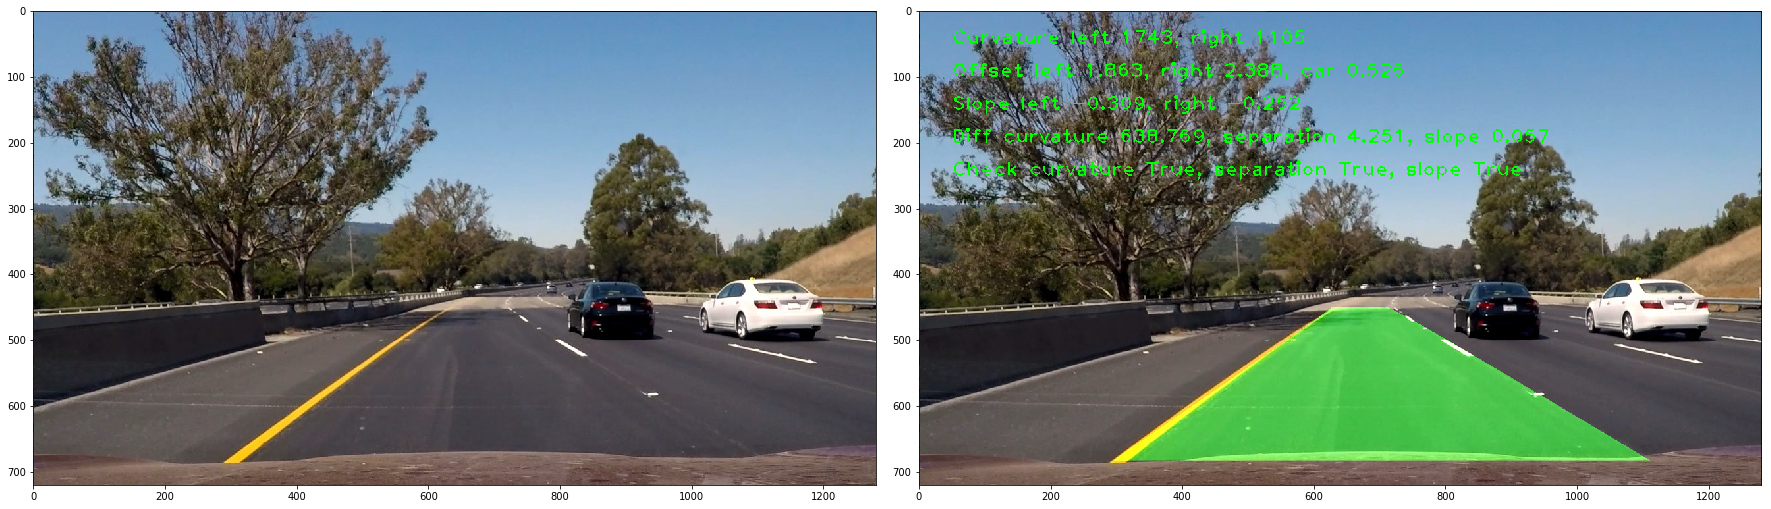

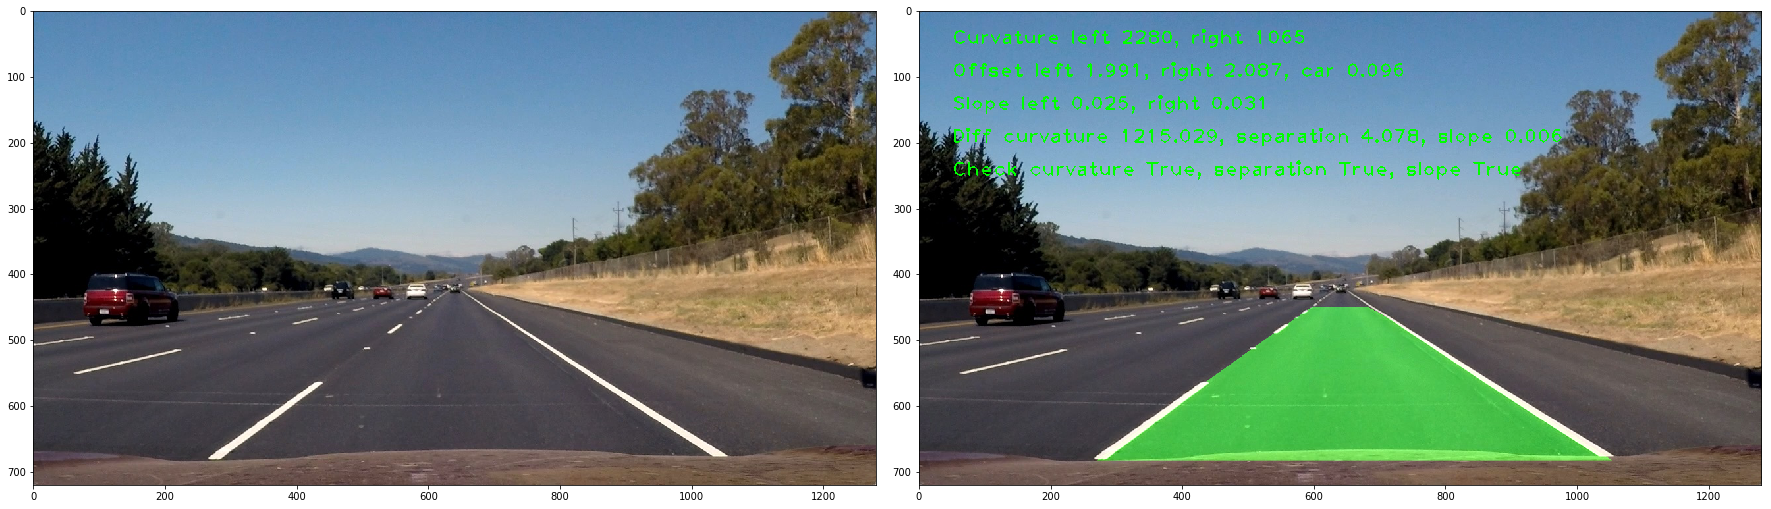

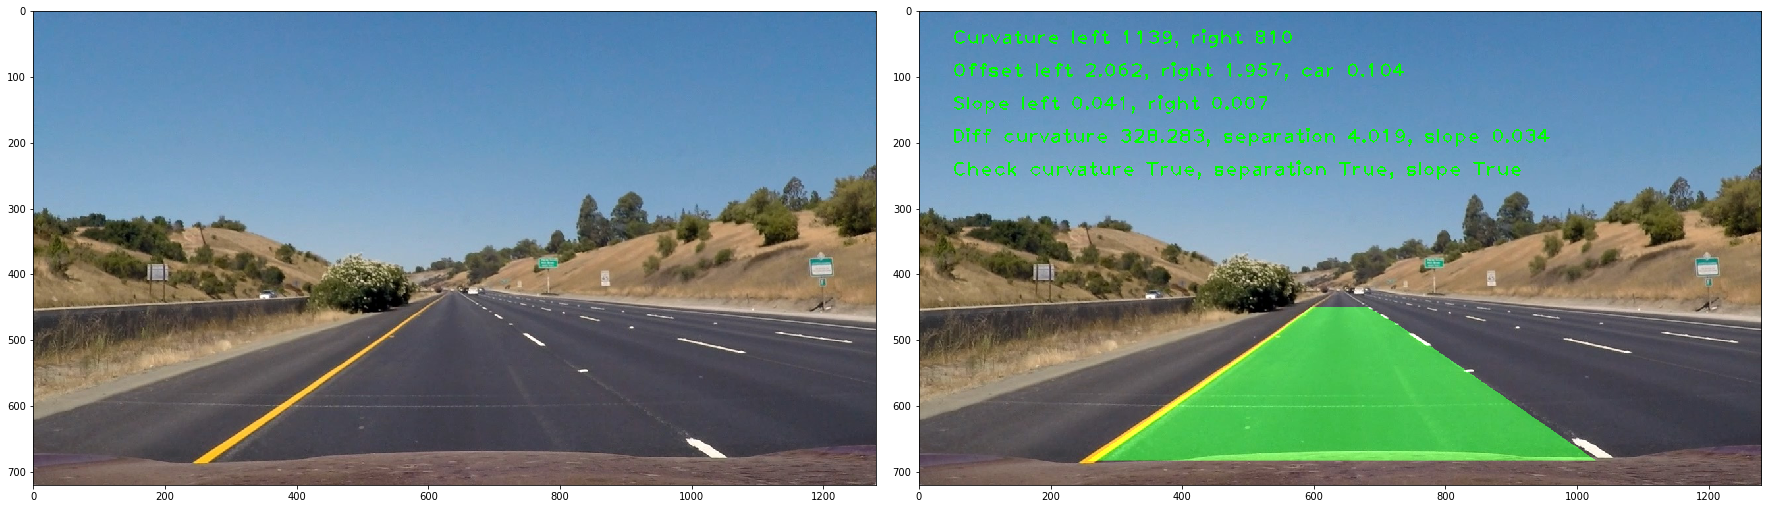

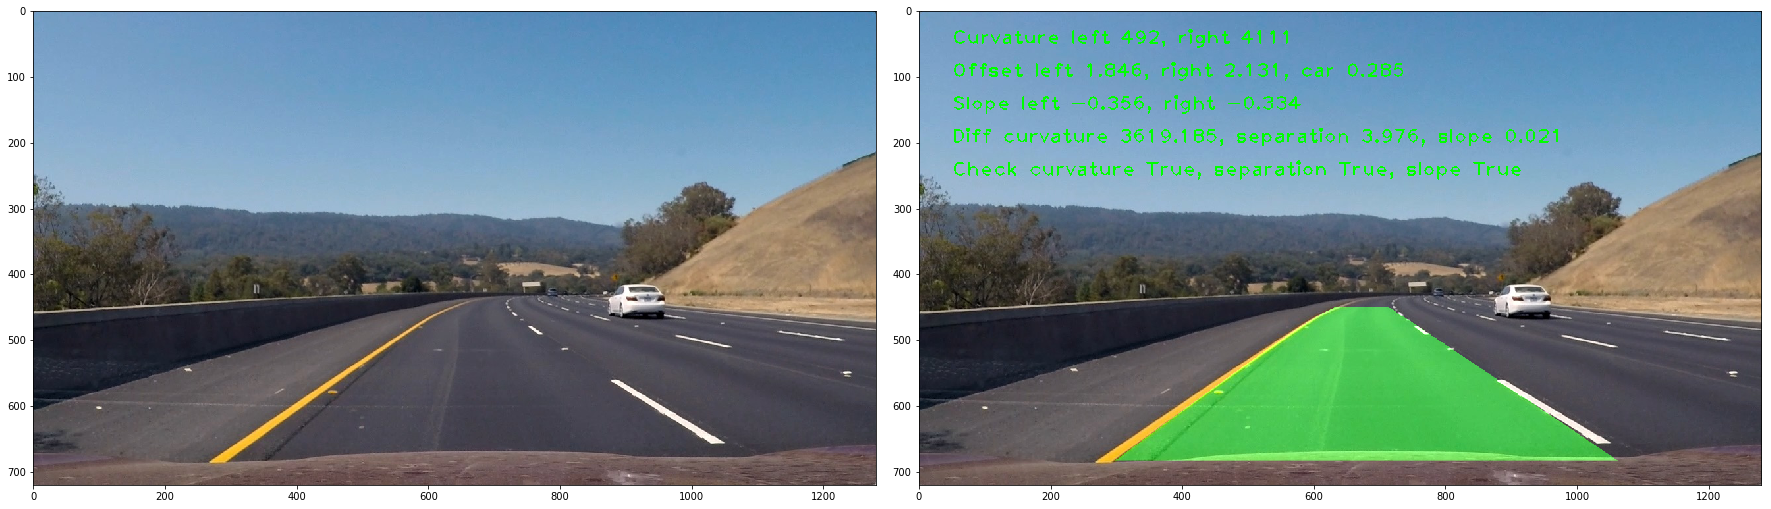

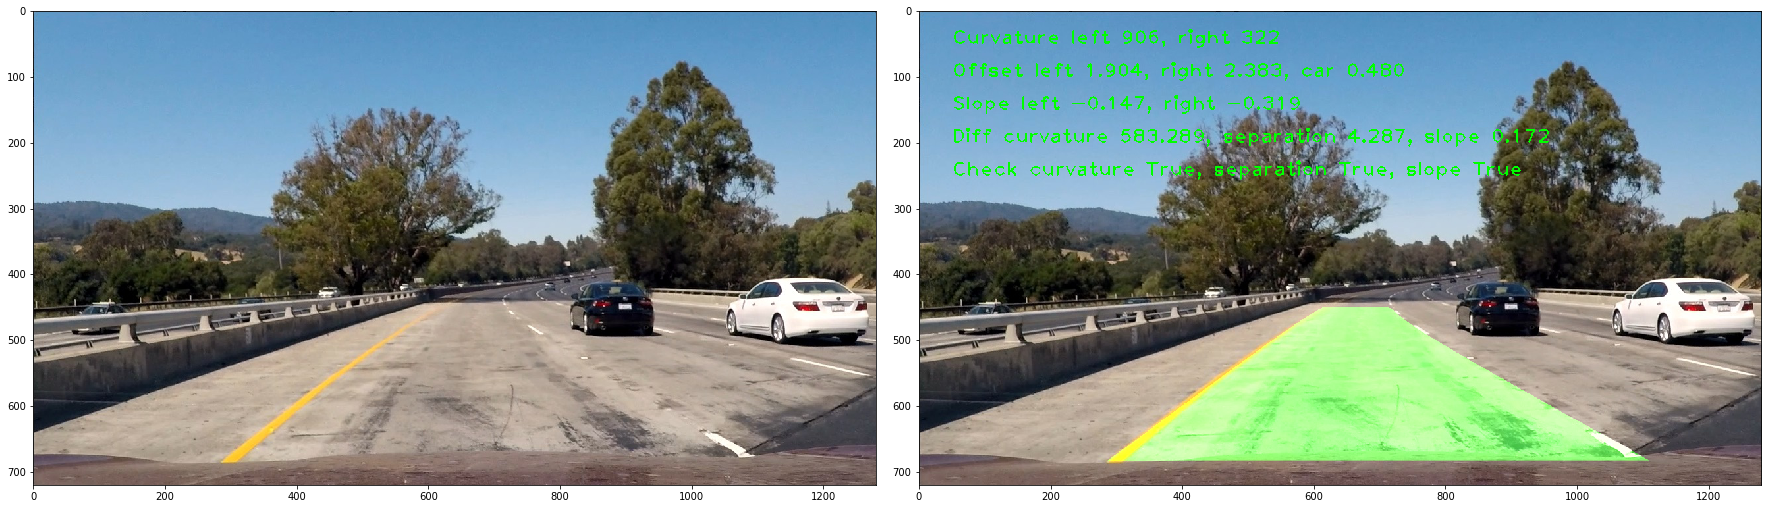

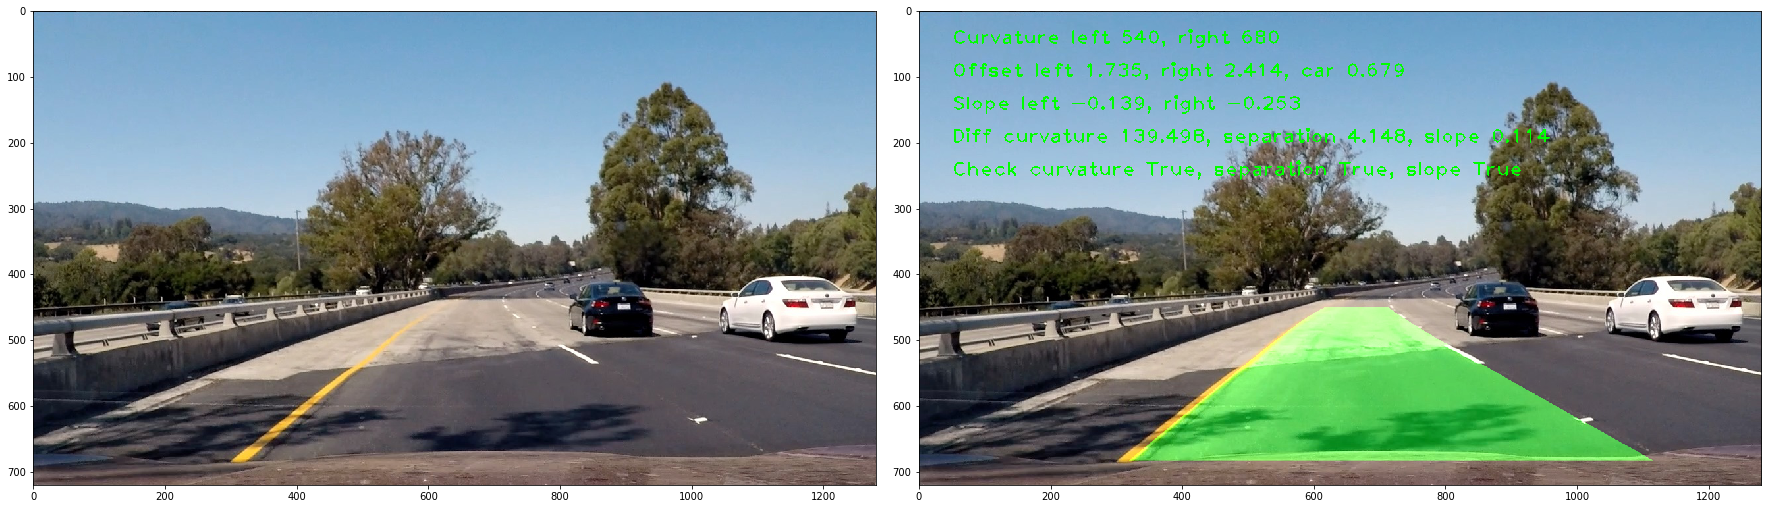

In [27]:
def process_image(img):
    lane_finder = LaneFinder(img_size, win_size, win_margin, m_per_pix, 1)
    return lane_finder.process(img)

proc_imgs = []

for img in test_imgs:
    proc_imgs.append(process_image(img))
    
show_img_pairs(test_imgs, proc_imgs)

## Utility functions for video processing

In [33]:
def process_video(input_path, output_path):
    lane_finder = LaneFinder(img_size, win_size, win_margin, m_per_pix, 5)
    test_video = VideoFileClip(input_path)
    output_video = test_video.fl_image(lane_finder.process)
    %time output_video.write_videofile(output_path, audio=False)
    
def embed_video(path):
    return HTML("""
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>
    """.format(path))

## Processing of test videos

In [34]:
process_video('test_videos/project_video.mp4', 'output_videos/project_video.mp4')
embed_video('output_videos/project_video.mp4')

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [03:14<00:00,  6.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 3min 46s, sys: 7.9 s, total: 3min 54s
Wall time: 3min 15s


In [31]:
#process_video('test_videos/challenge_video.mp4', 'output_videos/challenge_video.mp4')
embed_video('output_videos/challenge_video.mp4')

In [32]:
#process_video('test_videos/harder_challenge_video.mp4', 'output_videos/harder_challenge_video.mp4')
embed_video('output_videos/harder_challenge_video.mp4')